<a href="https://colab.research.google.com/github/curiosity806/2020_dacon_satellite_precipitation/blob/bogyung/Dacon_satellite_baseline_bg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Conv2DTranspose, MaxPooling2D, BatchNormalization, Activation, concatenate, Input, GlobalAveragePooling2D
from tensorflow.keras import Model
import warnings
import gc
 
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
tf.__version__

'2.2.0-rc3'

## 데이터 불러오기

In [0]:
# 구글 드라이브에서 데이터 파일 받아오기
# 시각화를 위한 것이므로 우선 1개의 파트만 받아오기
train_p0 = np.load('/content/drive/My Drive/2020 Kaggle Study/data/train/train_p0.npy')

In [0]:
test = np.load('/content/drive/My Drive/2020 Kaggle Study/data/32bits_data/test_32bits.npy')

In [0]:
# 훈련 데이터 및 자가 test데이터 불러오기
train = np.load('/content/drive/My Drive/2020 Kaggle Study/data/yeonung/train.npy')
test = np.load('/content/drive/My Drive/2020 Kaggle Study/data/32bits_data/test_32bits.npy')
# 테스트 데이터 받아오기
test_submit = np.load('/content/drive/My Drive/2020 Kaggle Study/data/test.npy')

In [9]:
train.shape

(76345, 40, 40, 15)

In [10]:
test.shape # test: 2416개, 40*40(각 픽셀에 해당하는 연속값), 14개 컬럼

(7639, 40, 40, 15)

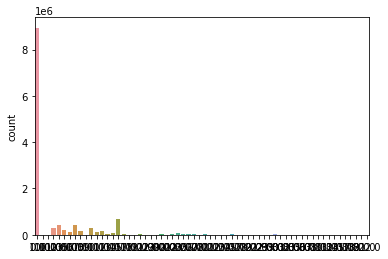

In [12]:
sns.countplot(test[:,:,:,9].flatten()) # 앞자리 0: Ocean, 앞자리 1: Land, 앞자리 2: Coastal, 앞자리 3: Inland Water

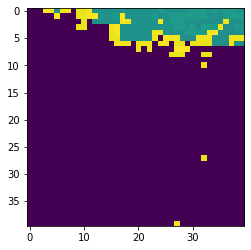

In [13]:
plt.imshow(test[-7,:,:,9]) # 각 픽셀별로 육지 바다 구분

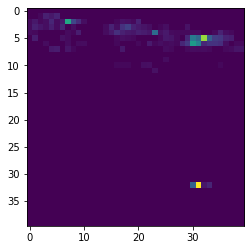

In [15]:
plt.imshow(train[-7,:,:,14]) # target(강수량)

In [0]:
# 재생산성을 위해 시드 고정
np.random.seed(7)
random.seed(7)
tf.random.set_seed(7)

# 정리 스타뜨~

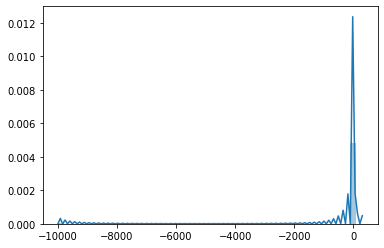

In [17]:
sns.distplot(train[:,:,:,-1].flatten())

In [18]:
train[:,:,:,-1].flatten().max()

299.9978

In [19]:
train[:,:,:,-1].flatten().min()

-9999.9

In [20]:
# 타겟 결측치(-9999.xx) 픽셀 갯수
sum(train[:,:,:,-1].flatten() < 0)

543756

In [21]:
# train 결측 비율
543756 / train[:,:,:,-1].flatten().shape[0] * 100

0.4451470299299234

## Missing Value 처리

In [0]:
target0 = train_p0[:,:,:,-1]
df = pd.DataFrame(target0.reshape(15269,1600)) # train0의 target 데이터프레임

In [19]:
null_index = []
for i in range(len(df)):
  if sum(df.loc[i,:] < 0) > 0:
    null_index.append(i)
  else:
    pass
null_index

[901,
 902,
 903,
 3129,
 3130,
 3131,
 3132,
 3133,
 5944,
 5945,
 5946,
 5947,
 5948,
 5949,
 8101,
 8102,
 8103,
 8104,
 8105,
 8106,
 8177,
 8178,
 8179,
 8180,
 8181,
 8182,
 8183,
 9286,
 9287,
 9288,
 9289,
 9290,
 9291,
 9292,
 9787,
 9788,
 9789,
 9790,
 9791,
 9792,
 10442,
 10443,
 10444,
 10445,
 10446,
 10447,
 11102,
 11103,
 11104,
 11105,
 11106,
 11107]

In [20]:
len(null_index)

52

In [21]:
df_null = df.loc[null_index,:]
df_null = df_null.reset_index()
df_null.head()

,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,1560,1561,1562,1563,1564,1565,1566,1567,1568,1569,1570,1571,1572,1573,1574,1575,1576,1577,1578,1579,1580,1581,1582,1583,1584,1585,1586,1587,1588,1589,1590,1591,1592,1593,1594,1595,1596,1597,1598,1599
0,901,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391
1,902,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,...,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391
2,903,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3129,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,...,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999

In [22]:
df[df.sum(axis=1) < 0].head() # 행 단위로 sum이 음수면 결측값이 포함된 것과 같다 (위의 null_index랑 동일함)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1560,1561,1562,1563,1564,1565,1566,1567,1568,1569,1570,1571,1572,1573,1574,1575,1576,1577,1578,1579,1580,1581,1582,1583,1584,1585,1586,1587,1588,1589,1590,1591,1592,1593,1594,1595,1596,1597,1598,1599
901,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391
902,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,...,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391
903,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3129,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,...,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.900391,-9999.9

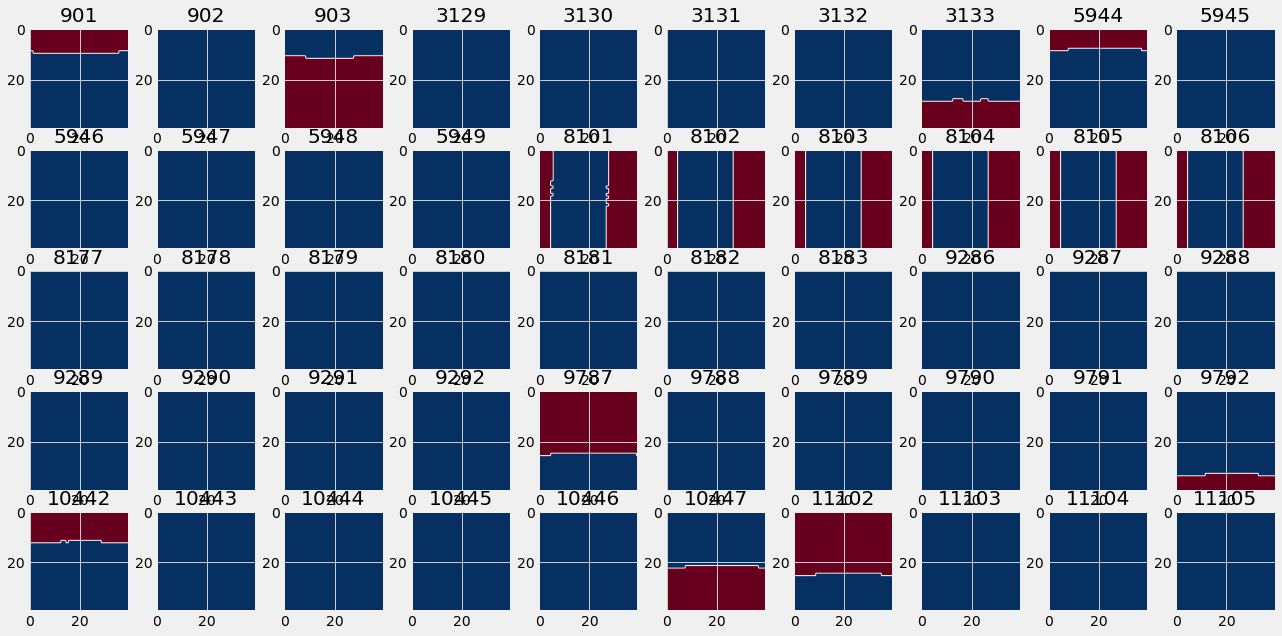

In [24]:
# 결측값 포함 target의 시각화
# 파란색: 결측값, 빨간색: 0 이상의 값
color_map = plt.cm.get_cmap('RdBu')
color_map = color_map.reversed()

plt.style.use('fivethirtyeight')
plt.figure(figsize=(20, 10))

for i in range(50):
    plt.subplot(5,10,i+1)
    plt.imshow(np.array(df_null.iloc[i, :], )[1:].reshape(40,40), cmap=color_map)
    plt.title(null_index[i])

plt.show()

결측치를 어떻게 채울것인가?\
1) 원본 train data 순서에 따라(위도, 경도, 시간 비슷)\
2) 그냥 0으로 처리(baseline)

## 시각화 하기

In [0]:
import seaborn as sns

In [0]:
color_map = plt.cm.get_cmap('RdBu')
color_map = color_map.reversed()

In [0]:
image_sample = train_p0[8]

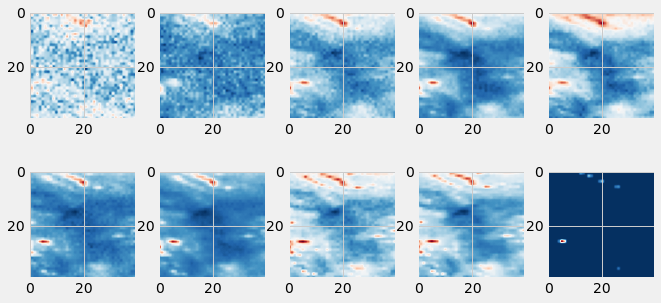

In [0]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 5))

for i in range(9):
    plt.subplot(2,5,i+1)
    plt.imshow(image_sample[:, :, i], cmap=color_map)

plt.subplot(2,5,10)
plt.imshow(image_sample[:,:,-1], cmap = color_map)
plt.show()

## 모델만들기

In [0]:
def build_model(input_layer, start_neurons):
    
    # 40 x 40 -> 20 x 20
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer) # filters, kernel_size
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(pool1)
    pool1 = Dropout(0.25)(pool1)

    # 20 x 20 -> 10 x 10
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(pool2)
    pool2 = Dropout(0.25)(pool2)

    # 10 x 10 
    convm = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)

    # 10 x 10 -> 20 x 20
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.25)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)

    # 20 x 20 -> 40 x 40
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.25)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Dropout(0.25)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation='relu')(uconv1)
    
    return output_layer

input_layer = Input((40, 40, 9))
output_layer = build_model(input_layer, 32)

In [0]:
model = Model(input_layer, output_layer)

In [0]:
from sklearn.metrics import f1_score

def mae(y_true, y_pred) :
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    
    y_pred = y_pred.reshape(1, -1)[0]
    
    over_threshold = y_true >= 0.1
    
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred):
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    
    y_pred = y_pred.reshape(1, -1)[0]
    
    remove_NAs = y_true >= 0
    
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    
    return(f1_score(y_true, y_pred))

def maeOverFscore(y_true, y_pred):
    
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def fscore_keras(y_true, y_pred):
    score = tf.py_function(func=fscore, inp=[y_true, y_pred], Tout=tf.float32, name='fscore_keras')
    return score

def maeOverFscore_keras(y_true, y_pred):
    score = tf.py_function(func=maeOverFscore, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse')
    return score

In [0]:
model.compile(loss="mae", optimizer="adam", metrics=[maeOverFscore_keras, fscore_keras])

## 데이터 제네레이터 만들기

In [0]:
data = train_p0
def trainGenerator():
    for file in data:
        target= file[:,:,-1].reshape(40,40,1)
        cutoff_labels = np.where(target < 0, 0, target) # 0보다 작으면(-9999.xx) 0으로 채우기
        feature = file[:,:,:9]
        
        if (cutoff_labels > 0).sum() < 50:
            continue
        yield (feature, cutoff_labels)
        
train_dataset = tf.data.Dataset.from_generator(trainGenerator,
                                               (tf.float32, tf.float32),
                                               (tf.TensorShape([40,40,9]),
                                                tf.TensorShape([40,40,1])))
train_dataset = train_dataset.batch(512).prefetch(1)

In [0]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
model_history = []
fold_number = 0

for train_index, test_index in kf.split(train):
    print(f'\nFold {fold_number}')
    fold_number = fold_number + 1
#-----------------------------------------------------------------------------
    def trainGenerator():
        for file in train[train_index]:
            target= file[:,:,-1].reshape(40,40,1)
            cutoff_labels = np.where(target < 0, 0, target)
            feature = file[:,:,:10]#########################land type 추가
            if (cutoff_labels > 0).sum() < 50:
                continue
            yield (feature, cutoff_labels)
    train_dataset = tf.data.Dataset.from_generator(trainGenerator,
                                                (tf.float32, tf.float32),
                                                (tf.TensorShape([40,40,10]),########################land type 추가
                                                    tf.TensorShape([40,40,1])))
    train_dataset = train_dataset.batch(512).prefetch(1)
#-----------------------------------------------------------------------------
    def testGenerator():
        for file in train[test_index]:
            target= file[:,:,-1].reshape(40,40,1)
            cutoff_labels = np.where(target < 0, 0, target)
            feature = file[:,:,:10]#########################land type 추가
            if (cutoff_labels > 0).sum() < 50:
                continue
            yield (feature, cutoff_labels)
    test_dataset = tf.data.Dataset.from_generator(testGenerator,
                                                (tf.float32, tf.float32),
                                                (tf.TensorShape([40,40,10]),########################land type 추가
                                                    tf.TensorShape([40,40,1])))
    test_size = len(test_index)
    test_dataset = test_dataset.batch(test_size).prefetch(1)
#-----------------------------------------------------------------------------

    history = model.fit(train_dataset, epochs = 10, verbose=1, validation_data = test_dataset)

    #history = model.fit(train_dataset, epochs = 5, ,batch_size = 11, verbose=1)
    model_history.append(history)
    #del data
    del train_dataset
    del test_dataset
    gc.collect()

## 모델 훈련하기
모델 훈련전에 GPU가 켜져있는지 확인!  
(런타임 -> 런타임 유형 변경-> 하드웨어 가속기-> GPU)

In [0]:
model_history = []

# 모든 데이터에 대해서 훈련할 것.
# 이미 메모리에 올라와 있는 train_p0를 메모리에서 제거
del train_p0
gc.collect()

# 5개로 분할된 데이터마다 각각 훈련을 진행
for i in range(5):
    data = np.load(f'/content/drive/My Drive/2020 Kaggle Study/data/train/train_p{i}.npy')
    train_dataset = tf.data.Dataset.from_generator(trainGenerator,
                                               (tf.float32, tf.float32),
                                               (tf.TensorShape([40,40,9]),
                                                tf.TensorShape([40,40,1])))
    train_dataset = train_dataset.batch(512).prefetch(1)
    history = model.fit(train_dataset, epochs = 5, verbose=1)
    #history = model.fit(train_dataset, epochs = 5, ,batch_size = 11, verbose=1)
    model_history.append(history)
    del data
    gc.collect()

Epoch 1/5
11/11 [==============================] - 7s 641ms/step - loss: 0.6314 - maeOverFscore_keras: 8.1239 - fscore_keras: 0.2425
Epoch 2/5
11/11 [==============================] - 7s 610ms/step - loss: 0.4331 - maeOverFscore_keras: 8.4301 - fscore_keras: 0.2358
Epoch 3/5
11/11 [==============================] - 6s 584ms/step - loss: 0.3706 - maeOverFscore_keras: 5.3010 - fscore_keras: 0.3574
Epoch 4/5
11/11 [==============================] - 6s 581ms/step - loss: 0.3172 - maeOverFscore_keras: 3.9976 - fscore_keras: 0.4366
Epoch 5/5
11/11 [==============================] - 6s 550ms/step - loss: 0.2935 - maeOverFscore_keras: 3.5580 - fscore_keras: 0.4802
Epoch 1/5
13/13 [==============================] - 8s 600ms/step - loss: 0.3238 - maeOverFscore_keras: 3.6504 - fscore_keras: 0.5285
Epoch 2/5
13/13 [==============================] - 7s 574ms/step - loss: 0.3178 - maeOverFscore_keras: 3.3952 - fscore_keras: 0.5620
Epoch 3/5
13/13 [==============================] - 7s 571ms/step - lo

## submission 만들기

In [0]:
pred = model.predict(X_test)

In [0]:
submission = pd.read_csv('/content/drive/My Drive/2020 Kaggle Study/data/sample_submission.csv')

In [0]:
submission.iloc[:,1:] = pred.reshape(-1, 1600)

In [0]:
submission.to_csv('Dacon_baseline_bg.csv', index = False)

In [0]:
# 제출파일 구글 드라이브에 올리기
!cp Dacon_baseline_bg.csv '/content/drive/My Drive/2020 Kaggle Study/submission'

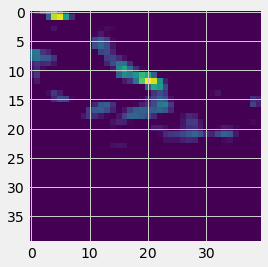

In [0]:
plt.imshow(submission.iloc[400,:][1:].astype('float64').values.reshape(40,40)) # 강수량~~!!

In [0]:
submission.astype('float64').values

array([[2985801.,       0.,       0., ...,       0.,       0.,       0.],
       [2985802.,       0.,       0., ...,       0.,       0.,       0.],
       [2985803.,       0.,       0., ...,       0.,       0.,       0.],
       ...,
       [3128802.,       0.,       0., ...,       0.,       0.,       0.],
       [3128808.,       0.,       0., ...,       0.,       0.,       0.],
       [3128811.,       0.,       0., ...,       0.,       0.,       0.]])

In [0]:
submission.iloc[:,1:].max().describe()

count    1600.000000
mean        5.817770
std         1.487400
min         0.834990
25%         4.821857
50%         5.791486
75%         6.827300
max        10.469974
dtype: float64